# Term 7 project: Inventory management
### Link to Original Github Repo: https://github.com/eg4000/SKU110K_CVPR19
### SKU-110K dataset can be found here: https://www.kaggle.com/datasets/thedatasith/sku110k-annotations/data 

In [6]:
import os
import tensorflow as tf
print(tf.__version__)
print("GPU Available:", tf.config.experimental.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dotenv

sku_dataset_dir = r"C:\Users\BLOOM\Documents\Github\term7cv\dataset\SKU110K_fixed"
annotations_dir = Path(sku_dataset_dir) / 'annotations'
images_path = Path(sku_dataset_dir) / 'images'

2.5.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


ImportError: Matplotlib requires numpy>=1.21; you have 1.19.5

## Delete corrupted images
- List: https://github.com/eg4000/SKU110K_CVPR19/issues/99#issuecomment-988886374

In [63]:
CORRUPTED_IMAGES = {
    "train": (
              "train_1239.jpg",
              "train_2376.jpg",
              "train_2903.jpg",
              "train_2986.jpg",
              "train_305.jpg",
              "train_3240.jpg",
              "train_340.jpg",
              "train_3556.jpg",
              "train_3560.jpg",
              "train_3832.jpg",
              "train_38.jpg",
              "train_4222.jpg",
              "train_5007.jpg",
              "train_5137.jpg",
              "train_5143.jpg",
              "train_5762.jpg",
              "train_5822.jpg",
              "train_6052.jpg",
              "train_6090.jpg",
              "train_6138.jpg",
              "train_6409.jpg",
              "train_6722.jpg",
              "train_6788.jpg",
              "train_737.jpg",
              "train_7576.jpg",
              "train_7622.jpg",
              "train_775.jpg",
              "train_7883.jpg",
              "train_789.jpg",
              "train_8020.jpg",
              "train_8146.jpg",
              "train_882.jpg",
              "train_903.jpg",
              "train_924.jpg"
             ),
    "validation": (
              "val_147.jpg",
              "val_286.jpg",
              "val_296.jpg",
              "val_386.jpg"
             ),
    "test": (
              "test_132.jpg",
              "test_1346.jpg",
              "test_184.jpg",
              "test_1929.jpg",
              "test_2028.jpg",
              "test_22.jpg",
              "test_2321.jpg",
              "test_232.jpg",
              "test_2613.jpg",
              "test_2643.jpg",
              "test_274.jpg",
              "test_2878.jpg",
              "test_521.jpg",
              "test_853.jpg",
              "test_910.jpg",
              "test_923.jpg"
             ),             
}

for subset, filenames in CORRUPTED_IMAGES.items():
    for filename in filenames:
        file_path = os.path.join(images_path, filename)
        if os.path.exists(file_path):
            os.remove(file_path)
            #print(f"Removed: {file_path}")
        else:
            pass
            #print(f"File not found: {file_path}")


## Preprocessing
- addressing OOM issue: reduce image size(4160x2336 to 416, 233), limit batch size, use tensorflow api

In [64]:
from PIL import Image
import io

def load_and_preprocess_data(annotations_file, images_path, subset_size=0.01, img_size=(416, 233), batch_size=256):
    df = pd.read_csv(annotations_file)
    subset = "train" if "train" in str(annotations_file) else "validation" if "val" in str(annotations_file) else "test"
    corrupted_images = CORRUPTED_IMAGES.get(subset, [])
    df = df[~df.iloc[:, 0].isin(corrupted_images)]
    df = df.sample(frac=subset_size, random_state=42).reset_index(drop=True)

    images_path = str(images_path)  # Convert images_path to string

    def preprocess(image_name, x1, y1, x2, y2, w, h):
        image_name = image_name.numpy().decode('utf-8')
        image_path = os.path.join(images_path, image_name)

        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)  # Resize image
        img = tf.image.convert_image_dtype(img, tf.float32)  # Normalize to [0, 1]

        x1, x2 = x1 / w, x2 / w
        y1, y2 = y1 / h, y2 / h

        bbox = tf.convert_to_tensor([y1, x1, y2, x2], dtype=tf.float32)  # TensorFlow format: [ymin, xmin, ymax, xmax]
        return img, bbox

    # Convert dataframe columns to tensors
    image_names = tf.convert_to_tensor(df[df.columns[0]].values, dtype=tf.string)
    x1 = tf.convert_to_tensor(df[df.columns[1]].values.astype(float), dtype=tf.float32)
    y1 = tf.convert_to_tensor(df[df.columns[2]].values.astype(float), dtype=tf.float32)
    x2 = tf.convert_to_tensor(df[df.columns[3]].values.astype(float), dtype=tf.float32)
    y2 = tf.convert_to_tensor(df[df.columns[4]].values.astype(float), dtype=tf.float32)
    w = tf.convert_to_tensor(df[df.columns[6]].values.astype(float), dtype=tf.float32)
    h = tf.convert_to_tensor(df[df.columns[7]].values.astype(float), dtype=tf.float32)

    dataset = tf.data.Dataset.from_tensor_slices((image_names, x1, y1, x2, y2, w, h))
    dataset = dataset.map(lambda img, x1, y1, x2, y2, w, h: tf.py_function(preprocess, [img, x1, y1, x2, y2, w, h], [tf.float32, tf.float32]))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

## Load data

In [65]:
subset_size = 0.01  # You can adjust this value as needed
img_size = (416, 233)  # Resize images to 224x224
batch_size = 64  # Number of samples per batch

train_data = load_and_preprocess_data(annotations_dir / 'annotations_train.csv', images_path, subset_size, img_size, batch_size)
val_data = load_and_preprocess_data(annotations_dir / 'annotations_val.csv', images_path, subset_size, img_size, batch_size)
test_data = load_and_preprocess_data(annotations_dir / 'annotations_test.csv', images_path, subset_size, img_size, batch_size)

## Visualise data

C:\Users\BLOOM\AppData\Local\Temp\ipykernel_22600\3197192673.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x1, y1, x2, y2 = row[1], row[2], row[3], row[4]


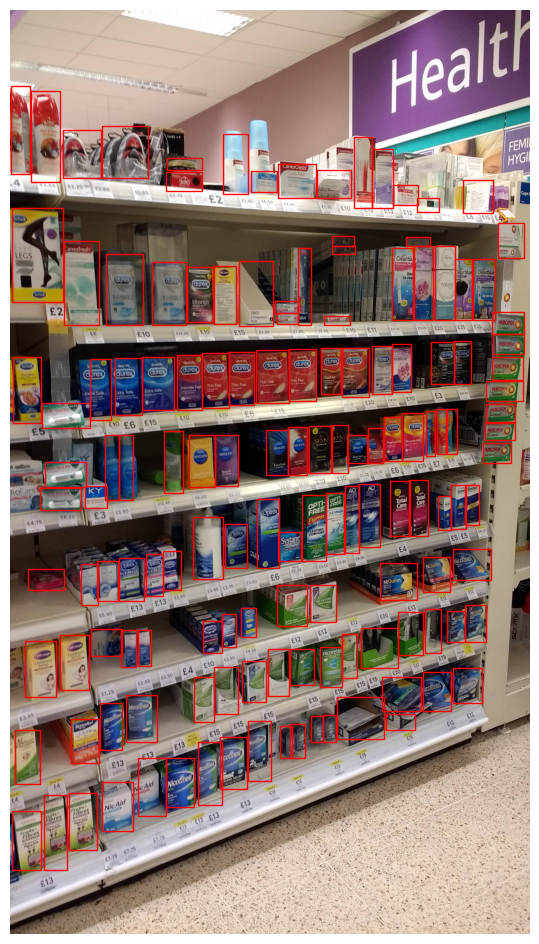

In [75]:
data_num, set = 10, 'test' 
image_num = sku_dataset_dir + rf'\images\{set}_{data_num}.jpg'
annotations_dir = Path(sku_dataset_dir) / 'annotations'
annotation_set_df = pd.read_csv("C:/Users/BLOOM/Documents/Github/term7cv/dataset/SKU110K_fixed" + f'/annotations/annotations_{set}.csv')
annotation_num = annotation_set_df[annotation_set_df.iloc[:, 0] == f'{set}_{data_num}.jpg']

def display_image_with_annotations(image_path, annotations_df):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.imshow(img)

    # Add the bounding boxes
    for index, row in annotations_df.iterrows():
        x1, y1, x2, y2 = row[1], row[2], row[3], row[4]
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Display the image with annotations
display_image_with_annotations(image_num, annotation_num)

## Predict
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow_hub as hub
import json

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

img_path = "dataset/SKU110K_fixed/images/val_110.jpg"

images = [
    'dataset/SKU110K_fixed/images/val_110.jpg',
    'dataset/SKU110K_fixed/images/val_116.jpg',
    'dataset/SKU110K_fixed/images/val_166.jpg',
    'dataset/SKU110K_fixed/images/val_400.jpg',
    'dataset/SKU110K_fixed/images/val_472.jpg',
]

## Export Ground Truth Annotations

In [ ]:
# import pandas as pd
# import json

# images = [
#     'val_110.jpg',
#     'val_116.jpg',
#     'val_166.jpg',
#     'val_400.jpg',
#     'val_472.jpg',
# ]

# # Read the Excel file
# annotations_df = pd.read_csv('dataset/SKU110K_fixed/annotations/annotations_val.csv')

# for image_name in images:
#     filtered_df = annotations_df.loc[annotations_df.iloc[:, 0] == image_name]

#     # Create a list of bounding box dictionaries
#     bounding_boxes = []
#     for _, row in filtered_df.iterrows():
#         bbox = {
#             "x_min": row.iloc[1],
#             "y_min": row.iloc[2],
#             "x_max": row.iloc[3],
#             "y_max": row.iloc[4],
#             # "width": row.iloc[5],
#             # "height": row.iloc[6],
#         }
#         bounding_boxes.append(bbox)

#     # Save the bounding boxes to annotations.json
#     with open(f'annotations/ground_truth/annotations_{image_name}.json', 'w') as f:
#         json.dump(bounding_boxes, f)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True)
    return str(model_dir)

MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_hg104_1024x1024_coco17_tpu-32'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

In [3]:
# Download labels file
def download_labels(filename):
    base_url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/'
    label_dir = tf.keras.utils.get_file(fname=filename,
                                        origin=base_url + filename,
                                        untar=False)
    label_dir = pathlib.Path(label_dir)
    return str(label_dir)

LABEL_FILENAME = 'mscoco_label_map.pbtxt'
PATH_TO_LABELS = download_labels(LABEL_FILENAME)

In [15]:
label_path = pathlib.Path(PATH_TO_LABELS)
model_path = pathlib.Path(PATH_TO_MODEL_DIR)
print(label_path)
print(model_path)

C:\Users\BLOOM\.keras\datasets\mscoco_label_map.pbtxt
C:\Users\BLOOM\.keras\datasets\centernet_hg104_1024x1024_coco17_tpu-32


In [16]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...

Done! Took 32.26076054573059 seconds


In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

IMAGE_PATHS = [
    'dataset/SKU110K_fixed/images/val_110.jpg',
    # 'dataset/SKU110K_fixed/images/val_116.jpg',
    # 'dataset/SKU110K_fixed/images/val_166.jpg',
    # 'dataset/SKU110K_fixed/images/val_400.jpg',
    # 'dataset/SKU110K_fixed/images/val_472.jpg',
]
category_index = {1: {'id': 1, 'name': 'object'}}
# category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Running inference for dataset/SKU110K_fixed/images/val_110.jpg... boxes: [[8.97213817e-01 1.43534288e-01 9.96865273e-01 1.74233750e-01]
 [4.74136949e-01 9.17614400e-01 5.72652578e-01 9.60775197e-01]
 [0.00000000e+00 2.00152397e-03 9.97639835e-01 9.98088956e-01]
 [4.44648981e-01 9.55890536e-01 5.72681308e-01 9.99558687e-01]
 [2.41616413e-01 6.82214797e-01 3.69986713e-01 7.37134874e-01]
 [4.43752825e-01 7.38084435e-01 5.62854886e-01 7.66801953e-01]
 [5.89241683e-01 1.75961107e-03 6.03884697e-01 4.91889119e-02]
 [4.50688779e-01 8.07942510e-01 5.67132890e-01 8.37647200e-01]
 [7.72601366e-01 9.40569758e-01 7.97516465e-01 9.70978618e-01]
 [8.91095877e-01 1.68401703e-01 9.99854684e-01 1.94218144e-01]
 [0.00000000e+00 2.00152397e-03 9.97639835e-01 9.98088956e-01]
 [6.11592889e-01 9.86782610e-01 7.06126094e-01 1.00000000e+00]
 [0.00000000e+00 1.21086836e-03 8.49911690e-01 9.98827994e-01]
 [5.90963006e-01 4.96029854e-04 6.23096704e-01 5.10107093e-02]
 [9.27830696e-01 8.60439360e-01 9.51680660e-0

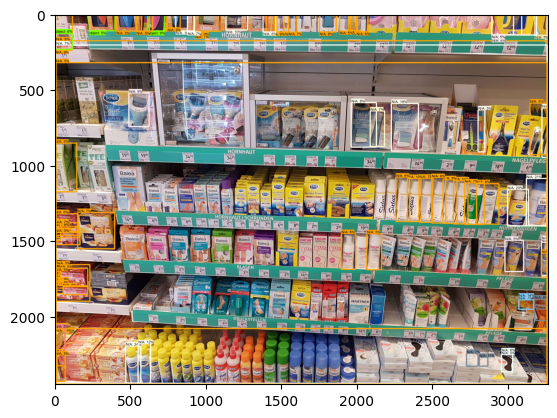

In [14]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))


for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    print("boxes:", detections['detection_boxes'],
          "classes:", detections['detection_classes'],
          "scores:", detections['detection_scores'])
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.05,
          agnostic_mode=False,
          line_thickness=8
        )

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()